general imports

In [183]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import numpy  
import matplotlib.pyplot as plt


Deep learning imports

In [184]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, LSTM, Dense, Dropout, Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split   
from tensorflow.keras.utils import plot_model   
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape, LSTM, Dense, Dropout
import math
from sklearn.metrics import mean_squared_error   
from tensorflow.keras.callbacks import EarlyStopping




data load

In [185]:
data = pd.read_csv("/home/mohammad/Desktop/Quantitave-Trading-/Data/APPL_closing.csv")   


In [186]:
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

data split

In [187]:

training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:1]

data about sets

In [188]:
print("Training data size:", training_size)
print("Test data size:", test_size)
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data size: 817
Test data size: 441
Training data shape: (817, 1)
Test data shape: (441, 1)


creating the timeseries format 

In [189]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [190]:
time_step = 100 
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [191]:
print(X_train.shape), print(y_train.shape)


(716, 100)
(716,)


(None, None)

model 

In [192]:
model = Sequential()

# First Conv1D layer for time series data
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(100, 1)))

# First MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))

# Second Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))

# Second MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))

# Third Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))

# Final MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))

# Flatten and reshape for LSTM input
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Reshape((100, 1)))

# LSTM layers
model.add(LSTM(25, return_sequences=True))  
model.add(LSTM(100))

# Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 100, 32)           128       
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 50, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, 50, 64)            6208      
                                                                 
 max_pooling1d_28 (MaxPooli  (None, 25, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_29 (Conv1D)          (None, 25, 128)           24704     
                                                                 
 max_pooling1d_29 (MaxPooli  (None, 12, 128)         

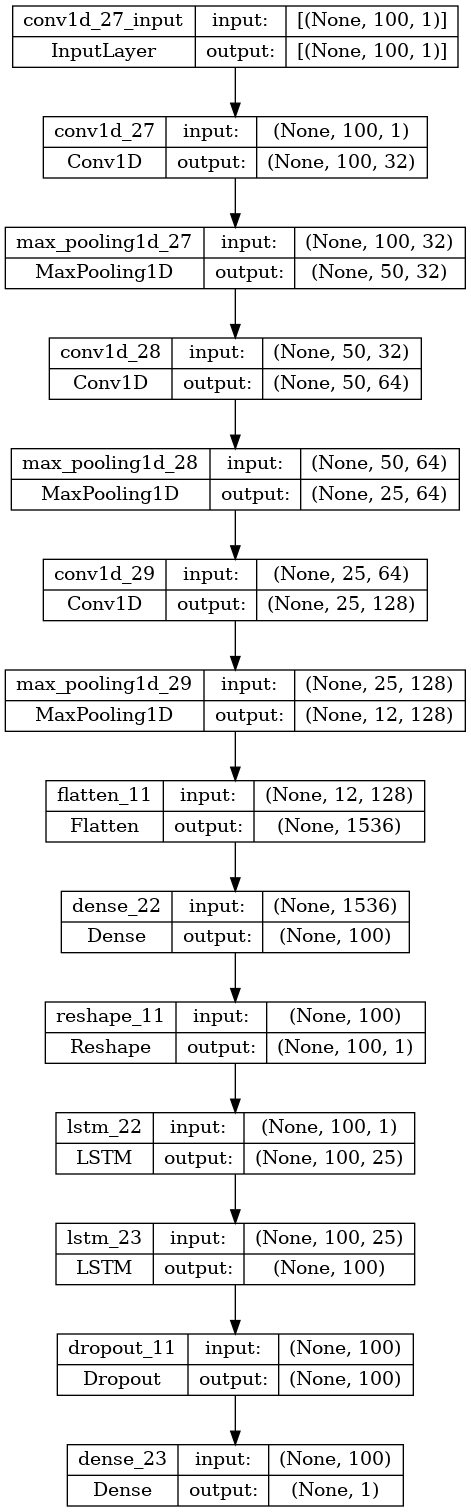

In [193]:
#plot the model 
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [194]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (716, 100, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)      # Similarly reshape X_test


Epoch 1/50
12/12 [==============================] - 3s 100ms/step - loss: 0.0363 - val_loss: 0.1867
Epoch 2/50
12/12 [==============================] - 1s 60ms/step - loss: 0.0126 - val_loss: 0.0178
Epoch 3/50
12/12 [==============================] - 1s 60ms/step - loss: 0.0040 - val_loss: 0.0110
Epoch 4/50
12/12 [==============================] - 1s 61ms/step - loss: 0.0030 - val_loss: 0.0139
Epoch 5/50
12/12 [==============================] - 1s 59ms/step - loss: 0.0027 - val_loss: 0.0175
Epoch 6/50
12/12 [==============================] - 1s 60ms/step - loss: 0.0024 - val_loss: 0.0134
Epoch 7/50
12/12 [==============================] - 1s 60ms/step - loss: 0.0019 - val_loss: 0.0136
Epoch 8/50
12/12 [==============================] - 1s 59ms/step - loss: 0.0017 - val_loss: 0.0094
Epoch 9/50
12/12 [==============================] - 1s 60ms/step - loss: 0.0017 - val_loss: 0.0097
Epoch 10/50
12/12 [==============================] - 1s 64ms/step - loss: 0.0015 - val_loss: 0.0105
Epoch 11

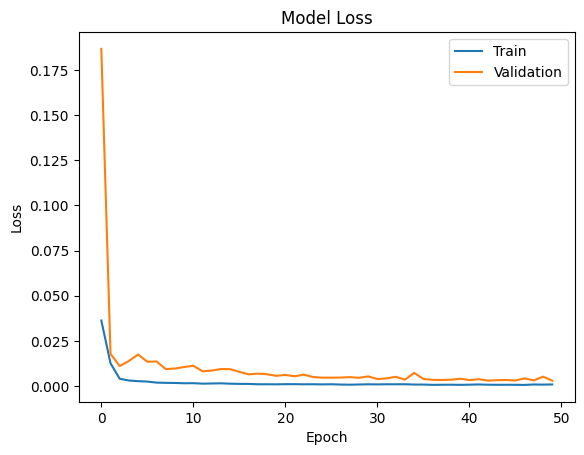

In [195]:
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Step 3: Add EarlyStopping to the fit method
HISTORY = model.fit(
    X_train, y_train,
    validation_data=(X_test, ytest),
    epochs=50,  # Maximum number of epochs
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(HISTORY.history['loss'])
plt.plot(HISTORY.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [196]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 11ms/step


In [197]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [198]:
math.sqrt(mean_squared_error(ytest,test_predict))


237.1299931620606

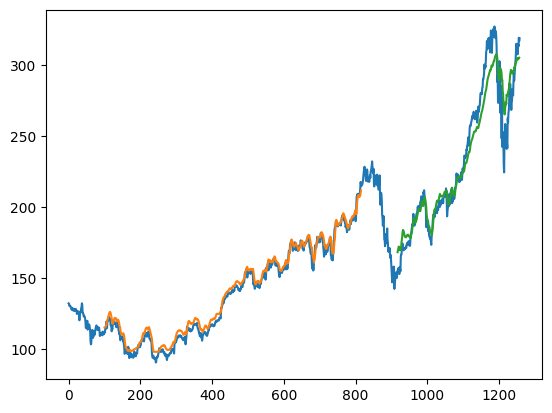

In [199]:
look_back=100
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

11/11 [==============================] - 0s 12ms/step


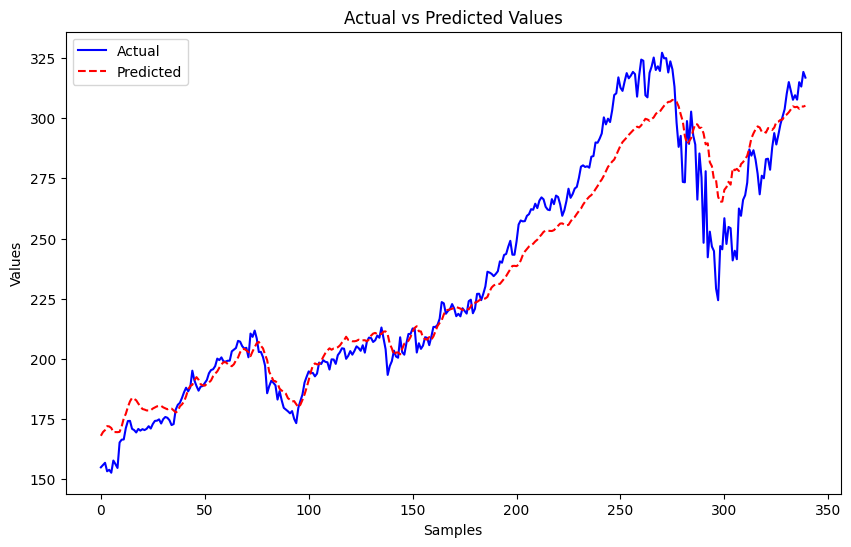

In [200]:
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
predictions = model.predict(X_test)

# If the data was scaled, you might need to inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

# Step 2: Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(ytest, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()
